# TCLab PCR Prototype Version 1

* **Feedforward Control** Feedforward control of the TCLab using a steady-state model.
* **Integrating Feedforward and Feedback Control** Improving setpoint response by adding feedback control.
* **Adding Constraints** Adding constrained optimization to the feedforward control calculations
* **Dynamic Setpoint Tracking** Tracking a desired temperature profile.

## Feedforward Control

In [13]:
%matplotlib notebook

from IPython.display import display
import ipywidgets as widgets
import tclab
import threading
import datetime

# parameter values
Ua = 0.0250
Ub = 0.0105
Ta = 22

def feedforward(SP1, SP2, Ta):
    Q1 = Ua*(SP1 - Ta) + Ub*(SP1 - SP2)
    Q2 = Ua*(SP2 - Ta) + Ub*(SP2 - SP1)
    return [Q1, Q2]

TCLab = tclab.setup(connected=False, speedup=5)

def work(output, stop, setpoint1, setpoint2, text):
    with output:
        with TCLab() as lab:

            # pre-run
            lab.P1 = 255
            lab.P2 = 255
            sources = [
                ('T1', lambda: lab.T1),
                ('T2', lambda: lab.T2),
                ('U1', lambda: lab.U1),
                ('U2', lambda: lab.U2),
                ('SP1', lambda: setpoint1.value),
                ('SP2', lambda: setpoint2.value)
            ]
            h = tclab.Historian(sources)
            p = tclab.Plotter(h, 1200, layout=(('T1', 'SP1'), ('T2', 'SP2'),('U1','U2')))

            # run
            for t in tclab.clock(10000, 5):
                Q1_ff, Q2_ff = feedforward(setpoint1.value, setpoint2.value, Ta)
                lab.U1 = max(0, min(100, 100*Q1_ff/lab.P1/0.013))
                lab.U2 = max(0, min(100, 100*Q2_ff/lab.P2/0.013))
                p.update(t)
                if stop.value:
                    text.value = "All done!"
                    break

            # post-run
            fname = datetime.datetime.now().strftime("data/data_%Y%M%dT%H%M%S.csv")
            h.to_csv(fname)
            print("Data saved to", fname)

# widgets
start = widgets.Button(description="Start", button_style="success")
stop = widgets.Button(description="Stop", button_style="")
text = widgets.Text(value='Hello World', description='Message', disabled=False)
setpoint1 = widgets.FloatSlider(value=50, min=0, max=120, step=1, description="Setpoint 1")
setpoint2 = widgets.FloatSlider(value=50, min=0, max=120, step=1, description="Setpoint 2")
output_plotter = widgets.Output(layout={'height': '500px', 'border': '1px solid black'})
output_controls = widgets.Output(layout={'height': '200px', 'border': '1px solid black'})

# thread
thread = threading.Thread(target=work, args=(output_plotter, stop, setpoint1, setpoint2, text))

# actions
def start_button_clicked(b):
    stop.value = False
    start.button_style = ""
    stop.button_style="success"
    thread.start()
    
start.on_click(start_button_clicked)

def stop_button_clicked(b):
    stop.value = True
    stop.button_style = ""
    thread.join()
    
stop.on_click(stop_button_clicked)

# START THINGS UP
display(output_controls)
with output_controls:
    display(widgets.HBox([start, stop]))
    display(widgets.HBox([setpoint1, setpoint2]))
    display(text)
display(output_plotter)

Output(layout=Layout(border='1px solid black', height='200px'))

Output(layout=Layout(border='1px solid black', height='500px'))

## Integrating Feedforward and Feedback Control

In [2]:
%matplotlib notebook

from IPython.display import display
import ipywidgets as widgets
import tclab
import threading
import datetime

# parameter values
Ua = 0.0250
Ub = 0.0105
Ta = 22

def feedforward(SP1, SP2, Ta):
    Q1 = Ua*(SP1 - Ta) + Ub*(SP1 - SP2)
    Q2 = Ua*(SP2 - Ta) + Ub*(SP2 - SP1)
    return [Q1, Q2]

def relay(MV_hi, MV_lo=0, h=1):
    MV = (MV_hi + MV_lo)/2
    while True:  
        SP, PV = yield MV      
        MV_prev = MV
        MV = MV_hi if PV < (SP - h) else MV_lo if PV > (SP + h) else MV_prev

TCLab = tclab.setup(connected=False, speedup=5)

def work(output, stop, setpoint1, setpoint2):
    with output:
        with TCLab() as lab:

            # pre-run
            lab.P1 = 255
            lab.P2 = 255
            sources = [
                ('T1', lambda: lab.T1),
                ('T2', lambda: lab.T2),
                ('U1', lambda: lab.U1),
                ('U2', lambda: lab.U2),
                ('SP1', lambda: setpoint1.value),
                ('SP2', lambda: setpoint2.value)
            ]
            h = tclab.Historian(sources)
            p = tclab.Plotter(h, 1200, layout=(('T1', 'SP1'), ('T2', 'SP2'),('U1','U2')))
            feedback1 = relay(1, -1)
            _ = feedback1.send(None)
            feedback2 = relay(1, -1)
            _ = feedback2.send(None)

            # run
            for t in tclab.clock(10000, 5):
                Q1_ff, Q2_ff = feedforward(setpoint1.value, setpoint2.value, Ta)
                Q1_fb = feedback1.send([setpoint1.value, lab.T1])
                Q2_fb = feedback2.send([setpoint2.value, lab.T2])
                lab.U1 = max(0, min(100, 100*(Q1_ff + Q1_fb)/lab.P1/0.013))
                lab.U2 = max(0, min(100, 100*(Q2_ff + Q2_fb)/lab.P2/0.013))
                p.update(t)
                if stop.value:
                    break

            # post-run
            fname = datetime.datetime.now().strftime("data/data_%Y%M%dT%H%M%S.csv")
            h.to_csv(fname)
            print("Data saved to", fname)

# widgets
start = widgets.Button(description="Start", button_style="success")
stop = widgets.Button(description="Stop", button_style="")
setpoint1 = widgets.FloatSlider(value=50, min=0, max=120, step=1, description="Setpoint 1")
setpoint2 = widgets.FloatSlider(value=50, min=0, max=120, step=1, description="Setpoint 2")
output_plotter = widgets.Output(layout={'height': '500px', 'border': '1px solid black'})
output_controls = widgets.Output(layout={'height': '90px', 'border': '1px solid black'})

# thread
thread = threading.Thread(target=work, args=(output_plotter, stop, setpoint1, setpoint2))

# actions
def start_button_clicked(b):
    stop.value = False
    start.button_style = ""
    stop.button_style="success"
    thread.start()
start.on_click(start_button_clicked)

def stop_button_clicked(b):
    stop.value = True
    stop.button_style = ""
    thread.join()
stop.on_click(stop_button_clicked)

# START THINGS UP
display(output_controls)
with output_controls:
    display(widgets.HBox([start, stop]))
    display(widgets.HBox([setpoint1, setpoint2]))
display(output_plotter)

Output(layout=Layout(border='1px solid black', height='90px'))

Output(layout=Layout(border='1px solid black', height='500px'))

## Steady State Control with Constraints

In [3]:
import numpy as np
import scipy.optimize

# decision variables Q1, Q2, T1, T2, z1p, z1m, z2p, z2m

Q_ps = 10
Q1_max = 3.3
Q2_max = 3.3
T_ub = 100

def feedforward_lp(SP1, SP2, Ta=20):
    c = np.array([0, 0, 0, 0, 1, 1, 1, 1])
    A_ub = np.array([
        [1, 1, 0, 0, 0, 0, 0, 0]
    ])
    b_ub = np.array([Q_ps])
    A_eq = np.array([
        [-1, 0, (Ua + Ub), -Ub, 0, 0, 0, 0],
        [0, -1, -Ub, (Ua + Ub), 0, 0, 0, 0],
        [0, 0, 1, 0, -1, 1, 0, 0],
        [0, 0, 0, 1, 0, 0, -1, 1]
    ])
    b_eq = np.array([Ua*Ta, Ua*Ta, SP1, SP2])
    bounds = [(0, Q1_max), (0, Q2_max), (Ta, T_ub), (Ta, T_ub), (0, None), (0, None), (0, None), (0, None)]
    results = scipy.optimize.linprog(c, A_ub, b_ub, A_eq, b_eq, bounds)
    Q1, Q2, T1, T2, _, _, _, _ = results.x
    return [Q1, Q2, T1, T2]

Q1, Q2, T1, T2 = feedforward_lp(103, 56)
Q1, Q2, T1, T2

(2.462, 0.43800000000000017, 100.0, 56.0)

In [4]:
%matplotlib notebook

from IPython.display import display
import ipywidgets as widgets
import tclab
import threading
import datetime

# parameter values
Ua = 0.0250
Ub = 0.0105
Ta = 22

def feedforward(SP1, SP2, Ta):
    Q1 = Ua*(SP1 - Ta) + Ub*(SP1 - SP2)
    Q2 = Ua*(SP2 - Ta) + Ub*(SP2 - SP1)
    return [Q1, Q2]

def relay(MV_hi, MV_lo=0, h=1):
    MV = (MV_hi + MV_lo)/2
    while True:  
        SP, PV = yield MV      
        MV_prev = MV
        MV = MV_hi if PV < (SP - h) else MV_lo if PV > (SP + h) else MV_prev

TCLab = tclab.setup(connected=False, speedup=5)

def work(output, stop, setpoint1, setpoint2):
    with output:
        with TCLab() as lab:

            # pre-run
            lab.P1 = 255
            lab.P2 = 255
            sources = [
                ('T1', lambda: lab.T1),
                ('T2', lambda: lab.T2),
                ('U1', lambda: lab.U1),
                ('U2', lambda: lab.U2),
                ('SP1', lambda: setpoint1.value),
                ('SP2', lambda: setpoint2.value),
                ('T1_ff', lambda: T1_ff),
                ('T2_ff', lambda: T2_ff)
            ]
            h = tclab.Historian(sources)
            p = tclab.Plotter(h, 1200, layout=(('T1', 'SP1', 'T1_ff'), ('T2', 'SP2','T2_ff'),('U1','U2')))
            feedback1 = relay(1, -1)
            _ = feedback1.send(None)
            feedback2 = relay(1, -1)
            _ = feedback2.send(None)

            # run
            for t in tclab.clock(10000, 5):
                Q1_ff, Q2_ff, T1_ff, T2_ff = feedforward_lp(setpoint1.value, setpoint2.value, Ta)
                Q1_fb = feedback1.send([T1_ff, lab.T1])
                Q2_fb = feedback2.send([T2_ff, lab.T2])
                lab.U1 = max(0, min(100, 100*(Q1_ff + Q1_fb)/lab.P1/0.013))
                lab.U2 = max(0, min(100, 100*(Q2_ff + Q2_fb)/lab.P2/0.013))
                p.update(t)
                if stop.value:
                    break

            # post-run
            fname = datetime.datetime.now().strftime("data_%Y%M%dT%H%M%S.csv")
            h.to_csv(fname)
            print("Data saved to", fname)

# widgets
start = widgets.Button(description="Start", button_style="success")
stop = widgets.Button(description="Stop", button_style="")
setpoint1 = widgets.FloatSlider(value=50, min=0, max=120, step=1, description="Setpoint 1")
setpoint2 = widgets.FloatSlider(value=50, min=0, max=120, step=1, description="Setpoint 2")
output_plotter = widgets.Output(layout={'height': '500px', 'border': '1px solid black'})
output_controls = widgets.Output(layout={'height': '90px', 'border': '1px solid black'})

# thread
thread = threading.Thread(target=work, args=(output_plotter, stop, setpoint1, setpoint2))

# actions
def start_button_clicked(b):
    stop.value = False
    start.button_style = ""
    stop.button_style="success"
    thread.start()
start.on_click(start_button_clicked)

def stop_button_clicked(b):
    stop.value = True
    stop.button_style = ""
    thread.join()
stop.on_click(stop_button_clicked)

# START THINGS UP
display(output_controls)
with output_controls:
    display(widgets.HBox([start, stop]))
    display(widgets.HBox([setpoint1, setpoint2]))
display(output_plotter)

Output(layout=Layout(border='1px solid black', height='90px'))

Output(layout=Layout(border='1px solid black', height='500px'))

## Setpoint Tracking

<IPython.core.display.Javascript object>


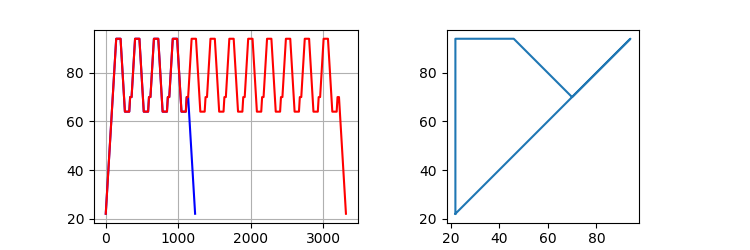

In [8]:
import glob
import matplotlib.pyplot as plt
import pandas as pd

def get_data(file1, file2):
    fig, ax = plt.subplots(1,2, figsize=(7.5,2.5))
    if file1:
        df1 = pd.read_csv(file1)
        ax[0].plot(df1['tp'], df1['Tp'], 'b')
    if file2:
        df2 = pd.read_csv(file2)
        ax[0].plot(df2['tp'], df2['Tp'], 'r')
    ax[0].grid(True)
    if file1 and file2:
        tmax = max(df1['tp'].max(), df2['tp'].max())
        t = np.linspace(0, tmax, int(tmax+1))
        u1 = lambda t: np.interp(t, df1['tp'].to_numpy(), df1['Tp'].to_numpy())
        u2 = lambda t: np.interp(t, df2['tp'].to_numpy(), df2['Tp'].to_numpy())
        ax[1].plot(u1(t), u2(t))
        ax[1].axis('square')
        return u1, u2

SP1, SP2 = get_data('pcr/pcr1.csv', 'pcr/pcr2.csv')

In [7]:
%matplotlib notebook

from IPython.display import display
import ipywidgets as widgets
import tclab
import threading
import datetime

# parameter values
Ua = 0.0250
Ub = 0.0105
Ta = 22

def feedforward(SP1, SP2, Ta):
    Q1 = Ua*(SP1 - Ta) + Ub*(SP1 - SP2)
    Q2 = Ua*(SP2 - Ta) + Ub*(SP2 - SP1)
    return [Q1, Q2]

def relay(MV_hi, MV_lo=0, h=1):
    MV = (MV_hi + MV_lo)/2
    while True:  
        SP, PV = yield MV      
        MV_prev = MV
        MV = MV_hi if PV < (SP - h) else MV_lo if PV > (SP + h) else MV_prev

TCLab = tclab.setup(connected=False, speedup=5)

def work(output, stop, setpoint1, setpoint2):
    with output:
        with TCLab() as lab:

            # pre-run
            lab.P1 = 255
            lab.P2 = 255
            sources = [
                ('T1', lambda: lab.T1),
                ('T2', lambda: lab.T2),
                ('U1', lambda: lab.U1),
                ('U2', lambda: lab.U2),
                ('SP1', lambda: setpoint1.value),
                ('SP2', lambda: setpoint2.value),
                ('T1_ff', lambda: T1_ff),
                ('T2_ff', lambda: T2_ff)
            ]
            h = tclab.Historian(sources)
            p = tclab.Plotter(h, 1200, layout=(('T1', 'SP1', 'T1_ff'), ('T2', 'SP2','T2_ff'),('U1','U2')))
            feedback1 = relay(1, -1)
            _ = feedback1.send(None)
            feedback2 = relay(1, -1)
            _ = feedback2.send(None)

            # run
            for t in tclab.clock(10000, 5):
                Q1_ff, Q2_ff, T1_ff, T2_ff = feedforward_lp(SP1(t), SP2(t), Ta)
                Q1_fb = feedback1.send([T1_ff, lab.T1])
                Q2_fb = feedback2.send([T2_ff, lab.T2])
                lab.U1 = max(0, min(100, 100*(Q1_ff + Q1_fb)/lab.P1/0.013))
                lab.U2 = max(0, min(100, 100*(Q2_ff + Q2_fb)/lab.P2/0.013))
                p.update(t)
                if stop.value:
                    break

            # post-run
            fname = datetime.datetime.now().strftime("data_%Y%M%dT%H%M%S.csv")
            h.to_csv(fname)
            print("Data saved to", fname)

# widgets
start = widgets.Button(description="Start", button_style="success")
stop = widgets.Button(description="Stop", button_style="")
setpoint1 = widgets.FloatSlider(value=50, min=0, max=120, step=1, description="Setpoint 1")
setpoint2 = widgets.FloatSlider(value=50, min=0, max=120, step=1, description="Setpoint 2")
output_plotter = widgets.Output(layout={'height': '500px', 'border': '1px solid black'})
output_controls = widgets.Output(layout={'height': '90px', 'border': '1px solid black'})

# thread
thread = threading.Thread(target=work, args=(output_plotter, stop, setpoint1, setpoint2))

# actions
def start_button_clicked(b):
    stop.value = False
    start.button_style = ""
    stop.button_style="success"
    thread.start()
start.on_click(start_button_clicked)

def stop_button_clicked(b):
    stop.value = True
    stop.button_style = ""
    thread.join()
stop.on_click(stop_button_clicked)

# START THINGS UP
display(output_controls)
with output_controls:
    display(widgets.HBox([start, stop]))
display(output_plotter)

Output(layout=Layout(border='1px solid black', height='90px'))

Output(layout=Layout(border='1px solid black', height='500px'))